

---
#<em> <font color='Purple'>Physics-Guided Deep Learning Lake Thermal Stratification Modelling</font> </em>
---

<Center> <b>Authors</b></Center>
<Center><i><em><font color='Grey'>Mohammed Aqid Khatkhatay, Tianxiao Shen, Ziwen Ye </em></i></Center>
<Center><i> Group 6, STAT GU4243/GR5243 - sec 2 </i></Center>
<Center><i> Columbia University</i></Center></font>
<br>
<Center> <b><i>Aim:</i></b></Center>
The goal of this project is to perform Lake Thermal Stratification Modelling and to explore and experiment not only the physics-guided deep learning models proposed in Read et al (2019) and Jia et al (2019), but also our own models. We shall also benchmark our models with the ones in the base papers in order to compare our results, evaluations and shortcomings.



| | |
|-|-|
| For a lake with D in given dates T, Given input drivers $ X \in D×T×F$, where F is feature dimensions, we aim to predict water temperature $Y \in R×D×T$|

---




# Research Oriented Problem Statement



1.   How does our proposed model perform compare to the PG-RNN?
2.   How does it perform in different experimental settings and conditions?
3.   Does a Spatial-Temporal model differ from a Temporal-Spatial model?
4.   How does the spatial modelling help to improve the performance of the lake temperature prediction?


#Code Initialization

## Code Repository Organisation GitHub

The repository can be found at 
https://github.com/aqid98/ClimatePredictionChallengesProject2

1.   Install Libraires.
2.   Create Directories on Colab.
3.   Download the utility files from GitHub.



In [ ]:
%%capture
!pip install sciencebasepy
!mkdir models
!mkdir models/Data
!mkdir Output
!wget https://raw.githubusercontent.com/aqid98/ClimatePredictionChallengesProject2/main/codes/dataset.py
!wget https://raw.githubusercontent.com/aqid98/ClimatePredictionChallengesProject2/main/codes/loss.py
!wget https://raw.githubusercontent.com/aqid98/ClimatePredictionChallengesProject2/main/codes/trainer.py
!wget https://raw.githubusercontent.com/aqid98/ClimatePredictionChallengesProject2/main/codes/utils.py
!wget https://raw.githubusercontent.com/aqid98/ClimatePredictionChallengesProject2/main/architectures/LSTM.py -P "/content/models"

In [ ]:
import os, random, warnings
import numpy as np
import pandas as pd
import sys
import torch
import warnings
warnings.filterwarnings("ignore")
import json


In [ ]:
def load_json(path):
    with open(path) as f:
        config = json.load(f)
    return config

def dump_json(config, path):
    with open(path, 'w') as f:
        json.dump(config, f, indent=4)


In [ ]:
import os, random, warnings
import numpy as np
import pandas as pd
import datetime
import torch
import re
import matplotlib.pyplot as plt
import sciencebasepy
import urllib.request
from sklearn import preprocessing
from urllib.request import urlopen
from zipfile import ZipFile


def download_data(data_dir):
    if os.listdir(data_dir) == []: ## data not downloaded yet
        print('Data folder is empty! Download the files now!')
        # set the url
        zipurl = 'https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges/raw/main/Project-StarterCodes/Project2-PhysicsML/data/numpy_files.zip'
        # download the file from the URL
        zipresp = urlopen(zipurl)
        # create a new file on the hard drive
        tempzip = open(data_dir + 'numpy_files.zip', "wb")
        # write the contents of the downloaded file into the new file
        tempzip.write(zipresp.read())
        # close the newly-created file
        tempzip.close()
        # re-open the newly-created file with ZipFile()
        zf = ZipFile(data_dir + 'numpy_files.zip')
        # extract its contents into <extraction_path>
        # note that extractall will automatically create the path
        zf.extractall(path = data_dir)
        # close the ZipFile instance
        zf.close()
        print('Files all downloaded!')
        
def read_data(data_dir, simulate = True):
    # load data
    x_full = np.load(data_dir + '/processed_features.npy') #standardized inputs
    x_raw_full = np.load(data_dir + '/features.npy') #raw inputs
    if simulate:
        diag_full = np.load(data_dir + '/diag.npy') 
        label_full = np.load(data_dir + '/labels.npy') #simulated lake temperatures

        # process data
        mask_full = np.ones(label_full.shape) # no missing values to mask for simulated data
        phy_full = np.concatenate((x_raw_full[:,:,:(-2)], diag_full), axis=2) 
        ## phy: 4-air temp, 5-rel hum, 6-wind speed, 9-ice flag
    else:
        diag_full = np.load(data_dir + 'diag.npy')
        label_full = np.load(data_dir + 'Obs_temp.npy') # real observation data
        mask_full = np.load(data_dir + 'Obs_mask.npy') # flags of missing values
        phy_full = np.concatenate((x_raw_full[:,:,:-2], diag_full), axis = 2) #physics variables
    full_dict = {
        'x':x_full,
        'x_raw': x_raw_full,
        'diag': diag_full,
        'label':label_full,
        'mask':mask_full,
        'phy':phy_full
    }
    return full_dict



def data_split(full_dict):
    N = full_dict['x'].shape[1]
    idx_tr, idx_va, idx_te = (int(N/3), int(N/3*2), N)
    
    train_dict = {}
    valid_dict = {}
    test_dict = {}
    train_full_dict = {}
    for key, val in full_dict.items():
        train_dict[key] = val[:, :idx_tr]
        valid_dict[key] = val[:, idx_tr:idx_va]
        train_full_dict[key] = val[:, :idx_va]
        
        test_dict[key] = val[:, idx_va:]
    return train_dict, valid_dict, train_full_dict, test_dict

def generate_samples(dict_, window_size = 352, strides = 352//2,):
    sample_dict = {}
    for key, val in dict_.items():
        sample_dict[key] = []
    
    size = dict_['x'].shape[1]
    for key, val in dict_.items():
        loc = 0
        while loc + window_size < size:
            
            tmp_array = val[:, loc: loc + window_size]
            tmp_array = np.expand_dims(tmp_array, axis = 0)
            sample_dict[key].append(tmp_array)
            
            loc += strides
        sample_dict[key] = np.vstack(sample_dict[key]).astype(np.float32)
    return sample_dict



## Download the data into the Data Folder

In [ ]:
download_data('/content/models/Data')

Data folder is empty! Download the files now!
Files all downloaded!


## Configure global variables

In [ ]:
config = {
    'data_dir': '/content/models/Data',
    'code_path': '/content/',
    'pre_train': True,
    'real_train':True,
    'model_name':'LSTM_encoder',
    'hidden_dim': 7 * 4,
    'learning_rate': 1e-2,
    'strides':4,
    'window_size':64,
    'batch_size':64,
    'mask_rate': 0.,
    'ec_loss': True,
    'seed': 100,
    'device': 'cuda:0',
    'output_dir': '/content/Output'
}


In [ ]:
global_result_dict = {}

# Main Modelling Function

In [ ]:
def main(args):
    sys.path.append(args['code_path']) 
    from models import LSTM
    from models import LSTM as models
    from loss import LakeLoss
    from utils import model_inference
    from trainer import Trainer
    from dataset import get_dataloader
    import tempfile

    
    data_dir = args['data_dir']
    device = args['device']
    seed = args['seed']
    np.random.seed(seed)
    torch.manual_seed(seed)
    strides = args['strides']
    window_size = args['window_size']
    batch_size = args['batch_size']
    learning_rate = args['learning_rate']
    ec_loss_flag = args['ec_loss']
    
    model = getattr(models, args['model_name'])(input_dim = 9, 
                                                output_dim = 1, 
                                                hidden_dim = args['hidden_dim'], 
                                                n_layers = 1)
    result = {}
    if args['pre_train']:
        tr_loader, va_loader, full_loader, te_loader = get_dataloader(path = data_dir, 
                                                              window_size = window_size,
                                                              strides = strides,
                                                              batch_size = batch_size,
                                                              mask_rate = 0,
                                                              simulate = True,
                                                              )
        trainer = Trainer(device = device, learning_rate=learning_rate)
        loss_func = LakeLoss(ec_loss = ec_loss_flag, device = device)
        model, epoch_info = trainer(model, loss_func, tr_loader, va_loader)
        trainer.epochs = epoch_info['epoch_no']
        trainer.early_stopping_patience = 100
        model = getattr(models, args['model_name'])(input_dim = 9, 
                                                output_dim = 1, 
                                                hidden_dim = args['hidden_dim'], 
                                                n_layers = 1)
        model, epoch_info_retrain = trainer(model, loss_func, full_loader, full_loader)
        
    temp_dir = tempfile.TemporaryDirectory(prefix="ts-temp-")
    path = f"{temp_dir.name}_best_model.pt"
    torch.save(model.state_dict(), path)

        
    tr_loader, va_loader, full_loader, te_loader = get_dataloader(path = data_dir, 
                                                              window_size = window_size,
                                                              strides = strides,
                                                              batch_size = batch_size,
                                                              mask_rate = args['mask_rate'],
                                                              simulate = False,
                                                              )
        
    if args['real_train']:
        loss_func = LakeLoss(ec_loss = ec_loss_flag, device = device)
        trainer = Trainer(device = device, learning_rate = learning_rate)

        model, epoch_info = trainer(model, loss_func, tr_loader, va_loader)
        
        
        model = getattr(models, args['model_name'])(input_dim = 9, 
                                                output_dim = 1, 
                                                hidden_dim = args['hidden_dim'], 
                                                n_layers = 1)
        model.load_state_dict(torch.load(path))
        trainer.epochs = epoch_info['epoch_no']
        trainer.early_stopping_patience = 100
        model, epoch_info_retrain = trainer(model, loss_func, full_loader, full_loader)

    test_loss, test_time = model_inference(model, te_loader, device = device)
    model_key_name = str(args['model_name'])+"_"+str(args['mask_rate'])+"_"+str(args['ec_loss'])+"_"+str(args['pre_train'])+"_"+str(args['real_train'])
    torch.save(model.state_dict(), '/content/Output/'+model_key_name+".pth")
    print('Fine-tune test loss is:', test_loss)
    args['real_loss'] = test_loss
    key = (args['model_name'],args['mask_rate'],args['ec_loss'],args['pre_train'],args['real_train'])
    global_result_dict[key] = args['real_loss']
    return args

# Training Models

1.   LSTM Base
2.   LSTM Depth CNN
3.   LSTM Attention
4.   LSTM Depth RNN
5.   LSTM Encoder

These model and their code can be found in 

```
models/LSTM.py
```

Saving model convention

```
{model_name}_{mask_rate}_{ec_loss_f}_{pre_train}
mask_rate can take values 0, 0.98, 0.8
ec_loss_f can take values True, False
pre_train can take values True, False
```

Training a single model takes around 8 minutes. You can change the seed and the other 4 paramters and experiment.
All weight files can be found on our shared google drive.
https://drive.google.com/drive/folders/1v6ELnMMq4KxOPsA_IthmQSr3wbnLfc5h?usp=sharing




## Proposed Model Evidence 



1.   LSTM Attention:<br>
    We propose LSTM Attention to store both depth and temperature information.
2.   LSTM Depth RNN Spatial: <br>
    We propose Depth RNN addition to store spatial information.
3.   LSTM Depth RNN Temporal: <br>
    We propose Depth RNN addition to store temporal information.
4.   LSTM Depth RNN Spatial Attention: <br>
    We propose Depth RNN with spatial attention to store spatial information.




# Proposed Methodology

<center>

## Spatio Temporal RNN

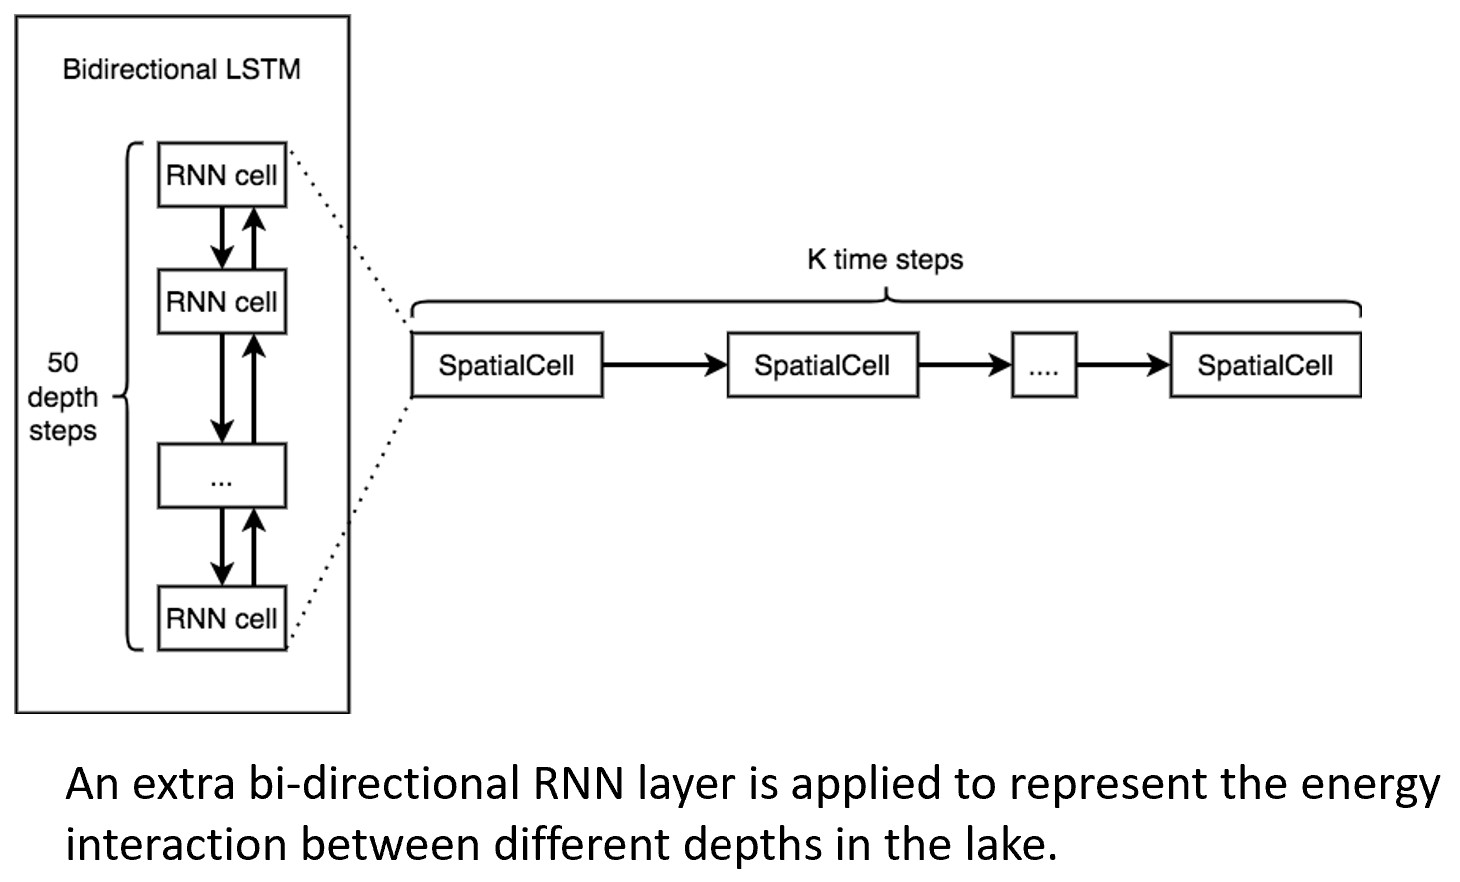

Figure 1: Shows our proposed framework for Spatial Temporal RNN model workflow

## Spatio Temporal PGRNN

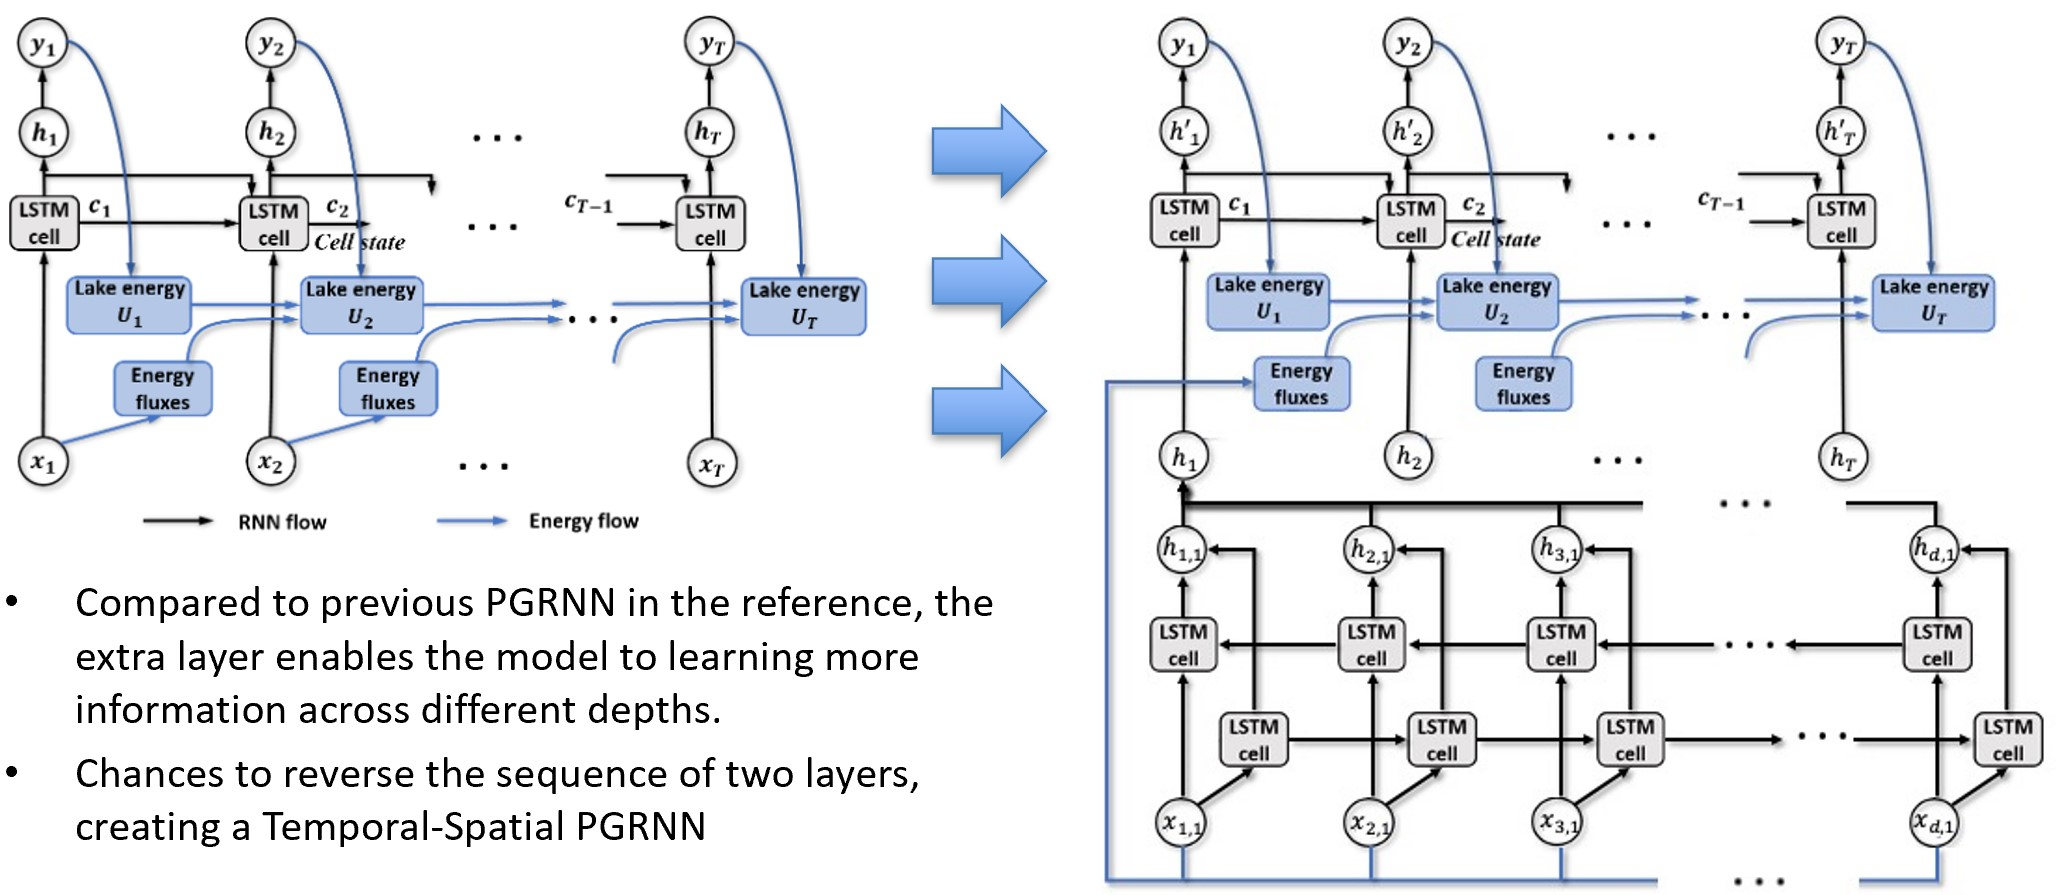

Figure 2: Shows our proposed framework for Spatial Temporal PGRNN model workflow

</center>

In [ ]:
import os

for seed in [1]:
  for model_name in ['LSTM_base', 'LSTM_attention','LSTM_depth_rnn_spatial','LSTM_depth_rnn_temporal','LSTM_depth_rnn_spatial_attn']:
    #for pre_train in [True, False]:
    for pre_train in [True]:
      #for ec_loss_f in [True, False]:
      for ec_loss_f in [True]:
        #for mask_rate in [0,0.8,0.98]:
        for mask_rate in [0.8,0.98]:
          for hidden_dim in [16]:
            config['model_name'] = model_name
            config['pre_train'] = pre_train
            config['mask_rate'] = mask_rate
            config['ec_loss'] = ec_loss_f
            config['seed'] = seed
            config['hidden_dim'] = hidden_dim
            args = main(config)

            from datetime import datetime
            time_mark = datetime.now().strftime("%m%d_%H%M%S")
            output_dir = args['output_dir']
            if not os.path.exists(output_dir): os.mkdir(output_dir)
            #dump_json(args, output_dir + f'/config_{time_mark}.json')
            dump_json(args, output_dir + f'/config_{model_name}_{mask_rate}_{ec_loss_f}_{pre_train}.json')

2022-03-08 16:35:01 INFO:113] Epoch[0] Elapsed time 0.688 seconds
2022-03-08 16:35:01 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=11.0352
2022-03-08 16:35:02 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=8.5350
2022-03-08 16:35:13 INFO:113] Epoch[10] Elapsed time 0.671 seconds
2022-03-08 16:35:13 INFO:117] Epoch[10] Evaluation metric 'epoch_loss'=1.4567
2022-03-08 16:35:13 INFO:117] Epoch[10] Evaluation metric 'validation_epoch_loss'=1.4733
2022-03-08 16:35:24 INFO:113] Epoch[20] Elapsed time 0.662 seconds
2022-03-08 16:35:24 INFO:117] Epoch[20] Evaluation metric 'epoch_loss'=1.0936
2022-03-08 16:35:25 INFO:117] Epoch[20] Evaluation metric 'validation_epoch_loss'=1.2736
2022-03-08 16:35:35 INFO:113] Epoch[30] Elapsed time 0.643 seconds
2022-03-08 16:35:35 INFO:117] Epoch[30] Evaluation metric 'epoch_loss'=1.0068
2022-03-08 16:35:36 INFO:117] Epoch[30] Evaluation metric 'validation_epoch_loss'=1.2460
2022-03-08 16:35:36 INFO:67] Early Stopping.
2022-03-08 16:35:37 I

Fine-tune test loss is: 1.553894768742954


2022-03-08 16:36:25 INFO:113] Epoch[0] Elapsed time 0.675 seconds
2022-03-08 16:36:25 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=11.0352
2022-03-08 16:36:26 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=8.5350
2022-03-08 16:36:37 INFO:113] Epoch[10] Elapsed time 0.675 seconds
2022-03-08 16:36:37 INFO:117] Epoch[10] Evaluation metric 'epoch_loss'=1.4567
2022-03-08 16:36:37 INFO:117] Epoch[10] Evaluation metric 'validation_epoch_loss'=1.4733
2022-03-08 16:36:48 INFO:113] Epoch[20] Elapsed time 0.659 seconds
2022-03-08 16:36:48 INFO:117] Epoch[20] Evaluation metric 'epoch_loss'=1.0936
2022-03-08 16:36:49 INFO:117] Epoch[20] Evaluation metric 'validation_epoch_loss'=1.2736
2022-03-08 16:37:00 INFO:113] Epoch[30] Elapsed time 0.666 seconds
2022-03-08 16:37:00 INFO:117] Epoch[30] Evaluation metric 'epoch_loss'=1.0068
2022-03-08 16:37:00 INFO:117] Epoch[30] Evaluation metric 'validation_epoch_loss'=1.2460
2022-03-08 16:37:00 INFO:67] Early Stopping.
2022-03-08 16:37:01 I

Fine-tune test loss is: 1.5487875096938188


2022-03-08 16:37:46 INFO:113] Epoch[0] Elapsed time 1.126 seconds
2022-03-08 16:37:46 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=8.5723
2022-03-08 16:37:47 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=4.3567
2022-03-08 16:38:02 INFO:113] Epoch[10] Elapsed time 1.002 seconds
2022-03-08 16:38:02 INFO:117] Epoch[10] Evaluation metric 'epoch_loss'=1.1717
2022-03-08 16:38:03 INFO:117] Epoch[10] Evaluation metric 'validation_epoch_loss'=1.3533
2022-03-08 16:38:18 INFO:113] Epoch[20] Elapsed time 1.015 seconds
2022-03-08 16:38:18 INFO:117] Epoch[20] Evaluation metric 'epoch_loss'=1.0046
2022-03-08 16:38:19 INFO:117] Epoch[20] Evaluation metric 'validation_epoch_loss'=1.2490
2022-03-08 16:38:25 INFO:67] Early Stopping.
2022-03-08 16:38:26 INFO:113] Epoch[0] Elapsed time 1.012 seconds
2022-03-08 16:38:26 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=9.4366
2022-03-08 16:38:27 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=5.6135
2022-03-08 16:38:43 INFO:

Fine-tune test loss is: 1.5146234841907726


2022-03-08 16:39:31 INFO:113] Epoch[0] Elapsed time 0.996 seconds
2022-03-08 16:39:31 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=8.5723
2022-03-08 16:39:31 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=4.3567
2022-03-08 16:39:47 INFO:113] Epoch[10] Elapsed time 1.003 seconds
2022-03-08 16:39:47 INFO:117] Epoch[10] Evaluation metric 'epoch_loss'=1.1717
2022-03-08 16:39:48 INFO:117] Epoch[10] Evaluation metric 'validation_epoch_loss'=1.3533
2022-03-08 16:40:03 INFO:113] Epoch[20] Elapsed time 1.019 seconds
2022-03-08 16:40:03 INFO:117] Epoch[20] Evaluation metric 'epoch_loss'=1.0046
2022-03-08 16:40:04 INFO:117] Epoch[20] Evaluation metric 'validation_epoch_loss'=1.2490
2022-03-08 16:40:10 INFO:67] Early Stopping.
2022-03-08 16:40:11 INFO:113] Epoch[0] Elapsed time 1.006 seconds
2022-03-08 16:40:11 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=9.4366
2022-03-08 16:40:12 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=5.6135
2022-03-08 16:40:27 INFO:

Fine-tune test loss is: 1.7526377474560457


2022-03-08 16:41:03 INFO:113] Epoch[0] Elapsed time 0.936 seconds
2022-03-08 16:41:03 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=10.4484
2022-03-08 16:41:03 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=7.9655
2022-03-08 16:41:18 INFO:113] Epoch[10] Elapsed time 0.924 seconds
2022-03-08 16:41:18 INFO:117] Epoch[10] Evaluation metric 'epoch_loss'=1.5773
2022-03-08 16:41:18 INFO:117] Epoch[10] Evaluation metric 'validation_epoch_loss'=1.5624
2022-03-08 16:41:33 INFO:113] Epoch[20] Elapsed time 0.932 seconds
2022-03-08 16:41:33 INFO:117] Epoch[20] Evaluation metric 'epoch_loss'=1.0516
2022-03-08 16:41:33 INFO:117] Epoch[20] Evaluation metric 'validation_epoch_loss'=1.2455
2022-03-08 16:41:41 INFO:67] Early Stopping.
2022-03-08 16:41:42 INFO:113] Epoch[0] Elapsed time 0.931 seconds
2022-03-08 16:41:42 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=10.6412
2022-03-08 16:41:42 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=9.0756
2022-03-08 16:41:57 INF

Fine-tune test loss is: 1.6812586433747236


2022-03-08 16:42:34 INFO:113] Epoch[0] Elapsed time 0.933 seconds
2022-03-08 16:42:34 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=10.4484
2022-03-08 16:42:34 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=7.9655
2022-03-08 16:42:49 INFO:113] Epoch[10] Elapsed time 0.943 seconds
2022-03-08 16:42:49 INFO:117] Epoch[10] Evaluation metric 'epoch_loss'=1.5773
2022-03-08 16:42:49 INFO:117] Epoch[10] Evaluation metric 'validation_epoch_loss'=1.5624
2022-03-08 16:43:04 INFO:113] Epoch[20] Elapsed time 0.932 seconds
2022-03-08 16:43:04 INFO:117] Epoch[20] Evaluation metric 'epoch_loss'=1.0516
2022-03-08 16:43:04 INFO:117] Epoch[20] Evaluation metric 'validation_epoch_loss'=1.2455
2022-03-08 16:43:12 INFO:67] Early Stopping.
2022-03-08 16:43:13 INFO:113] Epoch[0] Elapsed time 0.939 seconds
2022-03-08 16:43:13 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=10.6412
2022-03-08 16:43:13 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=9.0756
2022-03-08 16:43:28 INF

Fine-tune test loss is: 2.4528514953220593


2022-03-08 16:43:57 INFO:113] Epoch[0] Elapsed time 0.928 seconds
2022-03-08 16:43:57 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=10.2828
2022-03-08 16:43:57 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=7.2237
2022-03-08 16:44:11 INFO:113] Epoch[10] Elapsed time 0.923 seconds
2022-03-08 16:44:11 INFO:117] Epoch[10] Evaluation metric 'epoch_loss'=1.3393
2022-03-08 16:44:12 INFO:117] Epoch[10] Evaluation metric 'validation_epoch_loss'=1.5753
2022-03-08 16:44:26 INFO:113] Epoch[20] Elapsed time 0.932 seconds
2022-03-08 16:44:26 INFO:117] Epoch[20] Evaluation metric 'epoch_loss'=1.0129
2022-03-08 16:44:27 INFO:117] Epoch[20] Evaluation metric 'validation_epoch_loss'=1.2601
2022-03-08 16:44:30 INFO:67] Early Stopping.
2022-03-08 16:44:31 INFO:113] Epoch[0] Elapsed time 0.929 seconds
2022-03-08 16:44:31 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=10.1753
2022-03-08 16:44:31 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=7.8007
2022-03-08 16:44:46 INF

Fine-tune test loss is: 1.5737283001927769


2022-03-08 16:45:16 INFO:113] Epoch[0] Elapsed time 0.929 seconds
2022-03-08 16:45:16 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=10.2828
2022-03-08 16:45:16 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=7.2237
2022-03-08 16:45:30 INFO:113] Epoch[10] Elapsed time 0.928 seconds
2022-03-08 16:45:30 INFO:117] Epoch[10] Evaluation metric 'epoch_loss'=1.3393
2022-03-08 16:45:31 INFO:117] Epoch[10] Evaluation metric 'validation_epoch_loss'=1.5753
2022-03-08 16:45:45 INFO:113] Epoch[20] Elapsed time 0.926 seconds
2022-03-08 16:45:45 INFO:117] Epoch[20] Evaluation metric 'epoch_loss'=1.0129
2022-03-08 16:45:46 INFO:117] Epoch[20] Evaluation metric 'validation_epoch_loss'=1.2601
2022-03-08 16:45:49 INFO:67] Early Stopping.
2022-03-08 16:45:50 INFO:113] Epoch[0] Elapsed time 0.929 seconds
2022-03-08 16:45:50 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=10.1753
2022-03-08 16:45:50 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=7.8007
2022-03-08 16:46:05 INF

Fine-tune test loss is: 1.7758167140624102


2022-03-08 16:46:50 INFO:113] Epoch[0] Elapsed time 1.379 seconds
2022-03-08 16:46:50 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=8.9899
2022-03-08 16:46:50 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=4.8724
2022-03-08 16:47:11 INFO:113] Epoch[10] Elapsed time 1.377 seconds
2022-03-08 16:47:11 INFO:117] Epoch[10] Evaluation metric 'epoch_loss'=1.0418
2022-03-08 16:47:12 INFO:117] Epoch[10] Evaluation metric 'validation_epoch_loss'=1.2744
2022-03-08 16:47:32 INFO:113] Epoch[20] Elapsed time 1.379 seconds
2022-03-08 16:47:32 INFO:117] Epoch[20] Evaluation metric 'epoch_loss'=0.8398
2022-03-08 16:47:33 INFO:117] Epoch[20] Evaluation metric 'validation_epoch_loss'=1.1957
2022-03-08 16:47:33 INFO:67] Early Stopping.
2022-03-08 16:47:34 INFO:113] Epoch[0] Elapsed time 1.378 seconds
2022-03-08 16:47:34 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=8.5151
2022-03-08 16:47:35 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=4.6853
2022-03-08 16:47:55 INFO:

Fine-tune test loss is: 1.7013643489164465


2022-03-08 16:48:40 INFO:113] Epoch[0] Elapsed time 1.368 seconds
2022-03-08 16:48:40 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=8.9899
2022-03-08 16:48:41 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=4.8724
2022-03-08 16:49:01 INFO:113] Epoch[10] Elapsed time 1.387 seconds
2022-03-08 16:49:01 INFO:117] Epoch[10] Evaluation metric 'epoch_loss'=1.0418
2022-03-08 16:49:02 INFO:117] Epoch[10] Evaluation metric 'validation_epoch_loss'=1.2744
2022-03-08 16:49:22 INFO:113] Epoch[20] Elapsed time 1.382 seconds
2022-03-08 16:49:22 INFO:117] Epoch[20] Evaluation metric 'epoch_loss'=0.8398
2022-03-08 16:49:23 INFO:117] Epoch[20] Evaluation metric 'validation_epoch_loss'=1.1957
2022-03-08 16:49:23 INFO:67] Early Stopping.
2022-03-08 16:49:24 INFO:113] Epoch[0] Elapsed time 1.380 seconds
2022-03-08 16:49:24 INFO:117] Epoch[0] Evaluation metric 'epoch_loss'=8.5151
2022-03-08 16:49:25 INFO:117] Epoch[0] Evaluation metric 'validation_epoch_loss'=4.6853
2022-03-08 16:49:45 INFO:

Fine-tune test loss is: 2.0178624707109787


In [ ]:
for k,v in global_result_dict.items():
  print(k," model is "+str(round(v,2)))

('LSTM_base', 0, True, True, True)  model is 1.6
('LSTM_attention', 0, True, True, True)  model is 1.44
('LSTM_depth_rnn_spatial', 0, True, True, True)  model is 1.57
('LSTM_depth_rnn_temporal', 0, True, True, True)  model is 1.62
('LSTM_depth_rnn_spatial_attn', 0, True, True, True)  model is 1.54
('LSTM_base', 0.8, True, True, True)  model is 1.55
('LSTM_base', 0.98, True, True, True)  model is 1.55
('LSTM_attention', 0.8, True, True, True)  model is 1.51
('LSTM_attention', 0.98, True, True, True)  model is 1.75
('LSTM_depth_rnn_spatial', 0.8, True, True, True)  model is 1.68
('LSTM_depth_rnn_spatial', 0.98, True, True, True)  model is 2.45
('LSTM_depth_rnn_temporal', 0.8, True, True, True)  model is 1.57
('LSTM_depth_rnn_temporal', 0.98, True, True, True)  model is 1.78
('LSTM_depth_rnn_spatial_attn', 0.8, True, True, True)  model is 1.7
('LSTM_depth_rnn_spatial_attn', 0.98, True, True, True)  model is 2.02


> **⚠ Note: We ran the code snippets above for a huge number of expeirements.**  
> A description of the results obtained can be found the following table which can be easily replicated by changing parameters and data partition.
> The rubrics for this project requires the proposed model to run under 1 hour on Colab which is satisfied. 

# Results

## Results for RNN

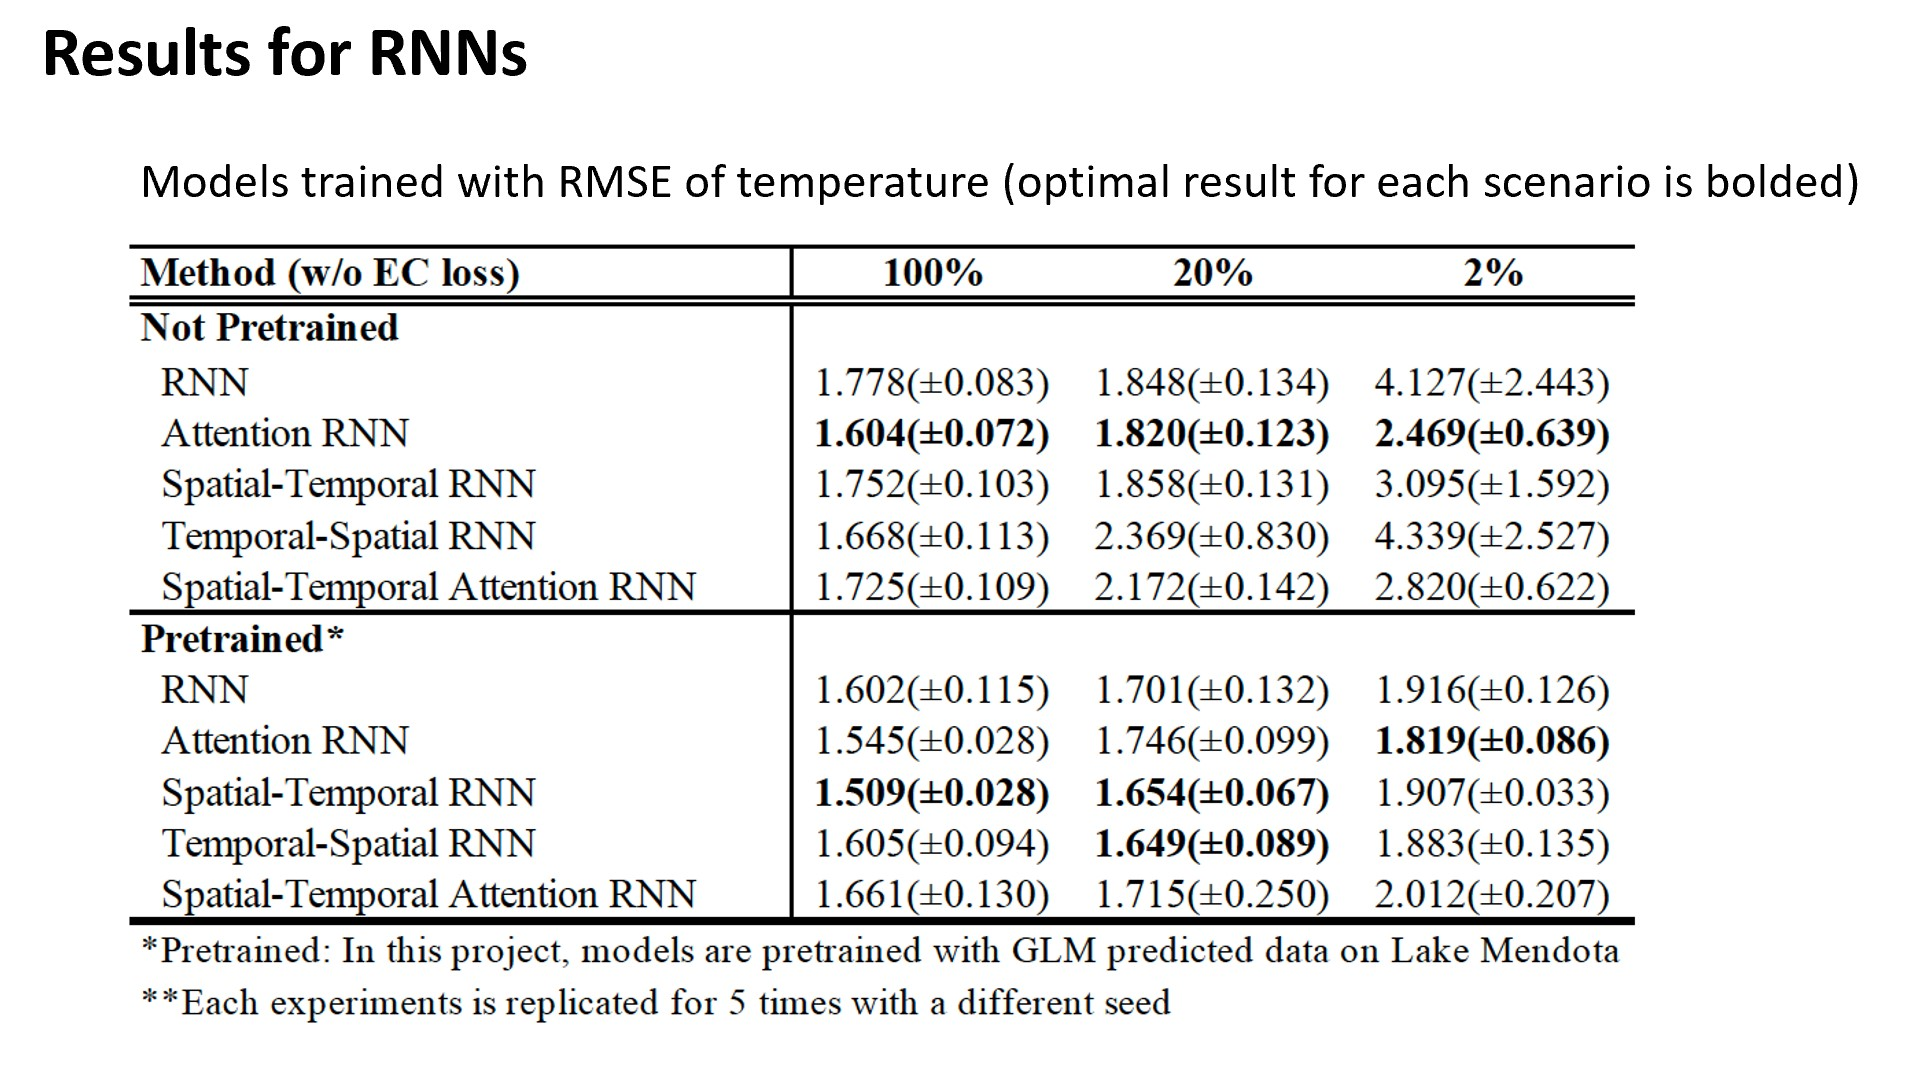

<center>Figure 3: Proposed RNN Spatio-Temporal </center>

## Results for PGRNN

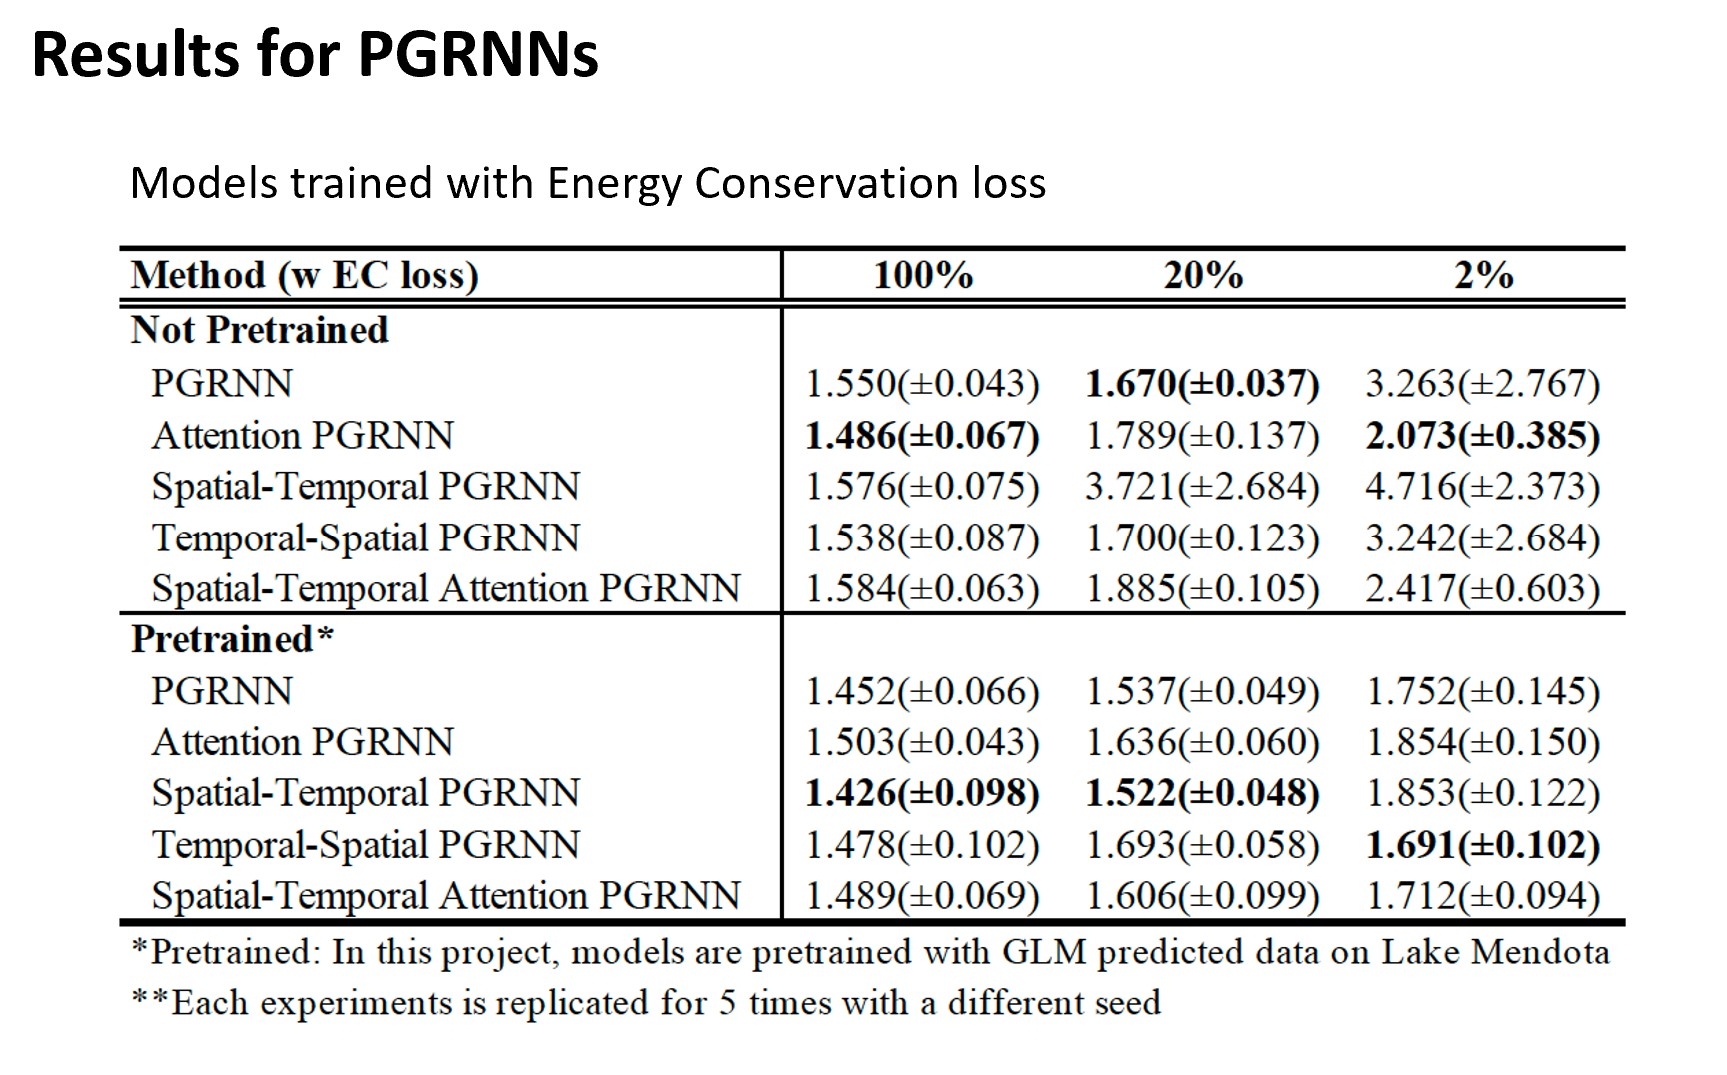

<center> Figure 4: Proposed PGRNN Spatio-Temporal </center>

## Insights and Evaluations

1.   We see that in almost all of the experiments our tested models perform better than the base model used in the paper.
2.   We plot the depth wise RMSE analysis as follows in order to infer how and where the Spatio-Temporal RNN, Temporo-Spatial RNN and Base RNN perform.

From experiments, we can infer that ST-RNN is greater than RNN, but where?
Why ST-RNN is greater than TS-RNN?
Thus we conducted in-depth analysis about model(w ec-loss, w pre-trained) perf.

The visualizations can be found in visualization.ipynb in the google drive and github





## Depth wise effect of RMSE.
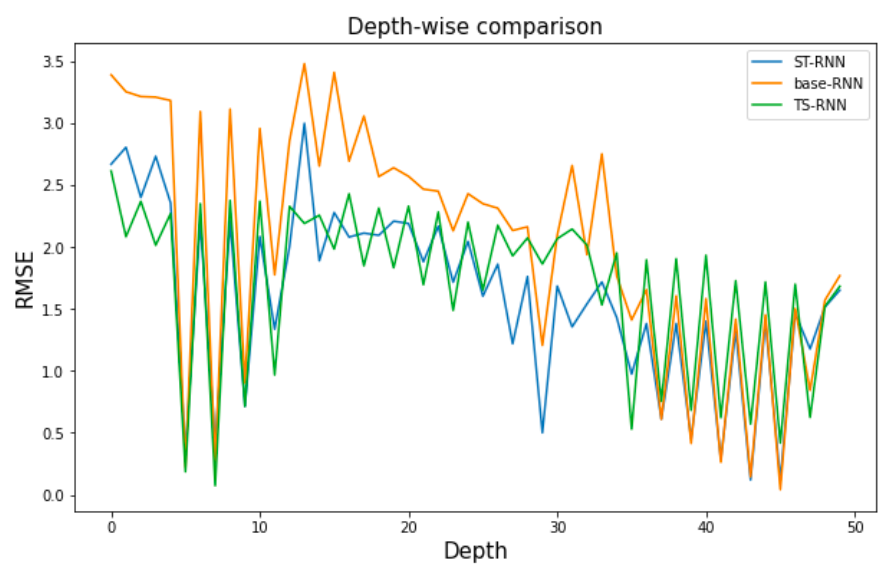


<center>
Figure 5. RMSE vs Depth
</center>

## Temperature vs Depth Analysis for 2003

<center>

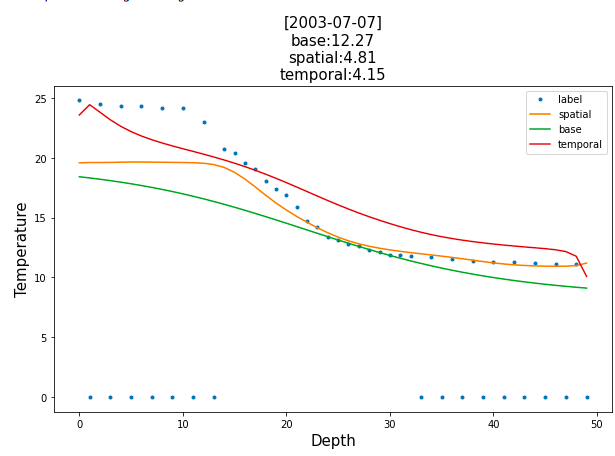
</center>
<center> Figure 6: RMSE predicted vs observed for the year 2003  </center>

## Temperature vs Depth Analysis for 2007

<center>

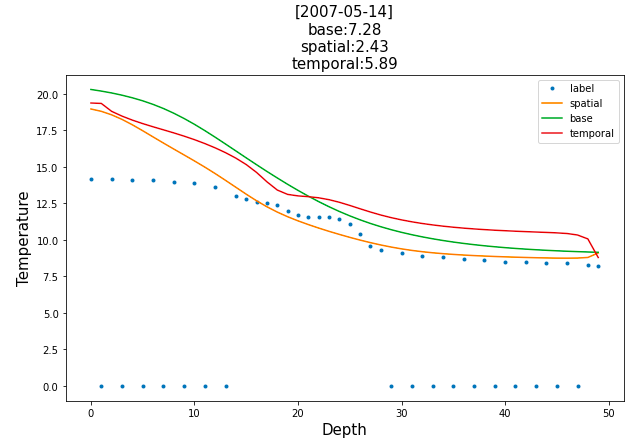

</center>

<center> Figure 7: RMSE predicted vs observed for the year 2007  </center>

# References

1.   Read, JS, Jia, X, Willard, J, Appling, AP, Zwart, JA, Oliver, SK,
Karpatne, A, Hansen, GJA, Hanson, PC, Watkins, W, Steinbach, M
Kumar, V 2019, ’Process-Guided Deep Learning Predictions of Lake
Water Temperature’ https://doi.org/10.1029/2019WR024922
2.   Jia, X, Willard, J, Karpatne, A, Read, J, Zwart, J, Steinbach, MS
Kumar, V 2019, Physics guided RNNs for modeling dynamical
systems: A case study in simulating lake temperature profiles. https://doi.org/10.1137/1.9781611975673.63
3.    Jia, X., Willard, J., Karpatne, A., Read, J. S., Zwart, J. A., Steinbach,
M., Kumar, V. (2021). Physics-guided machine learning for scientific
discovery: An application in simulating lake temperature profiles.

